In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import random
from pydantic import BaseModel, ValidationError
from typing import List
import uuid 

## 1. Number of transactions per day

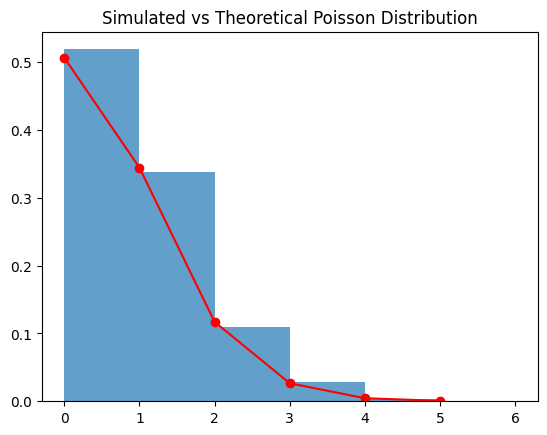

In [3]:
# 251 transactions per year = 0.68 transactions per day
daily_txn = np.random.poisson(0.68, size=1000)
plt.hist(daily_txn, bins=range(max(daily_txn)+2), density=True, alpha=0.7)
x = range(max(daily_txn)+1)
plt.plot(x, stats.poisson.pmf(x, 0.68), 'ro-')
plt.title('Simulated vs Theoretical Poisson Distribution')
plt.show()

## 2. Value of each transaction

In [4]:
def compute_sigma(mean:float, cv:float) -> float:
    """ 
    a formula to calculate sigma from mean and CV
    """
    variance = (mean * cv)**2
    sigma_sq = np.log(1 + variance/(mean**2))
    sigma = np.sqrt(sigma_sq)
    # get the value from numpy array
    return sigma.item()

In [5]:
compute_sigma(mean=96.49, cv=0.75)

0.6680472308365776

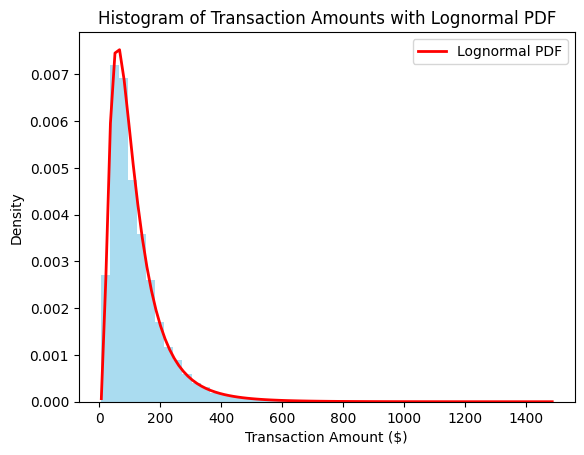

In [6]:
# Generate lognormal txn_value
mean = 96.49
sigma = 0.6873
size = 10000
txn_value = np.random.lognormal(mean=np.log(mean), sigma=sigma, size=size)

# Create histogram
plt.hist(txn_value, bins=50, density=True, alpha=0.7, color='skyblue')

# Calculate PDF
x = np.linspace(txn_value.min(), txn_value.max(), 100)
pdf = stats.lognorm.pdf(x, s=sigma, scale=np.exp(np.log(mean)))

# Plot PDF
plt.plot(x, pdf, 'r-', lw=2, label='Lognormal PDF')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Density')
plt.title('Histogram of Transaction Amounts with Lognormal PDF')
plt.legend()
plt.show()

## 3. Consolidated Customer spending profile

In [7]:
# create a dictionary to contain profiles abvoe for the uniform distributions of mean and CV:
group_profiles = {
    'name': ['low', 'low-middle', 'middle', 'high-middle', 'high'],
    'txn_mean_low': [5, 20, 40, 60, 80],
    'txn_mean_high': [20, 40, 60, 80, 100],
    'txn_cv_low': [0.3, 0.4, 0.5, 0.6, 0.7],
    'txn_cv_high': [0.4, 0.5, 0.6, 0.7, 0.8],
    'txn_lambda': [0.25, 0.5, 1, 1.5, 2] # to simplify, we assume middle income person has average 1 txn per day
}

class GroupProfiles(BaseModel):
    name: List[str]
    txn_mean_low: List[float]
    txn_mean_high: List[float]
    txn_cv_low: List[float]
    txn_cv_high: List[float]
    txn_lambda: List[float]

# Validate the input dictionary using assert
try:
    validated_profiles = GroupProfiles(**group_profiles)
    assert validated_profiles
    print("Validation successful!")
except ValidationError as e:
    assert False, f"Validation failed: {e}"

# visualize in a table
df = pd.DataFrame(group_profiles)
df


Validation successful!


,name,txn_mean_low,txn_mean_high,txn_cv_low,txn_cv_high,txn_lambda
0,low,5,20,0.3,0.4,0.25
1,low-middle,20,40,0.4,0.5,0.50
2,middle,40,60,0.5,0.6,1.00
3,high-middle,60,80,0.6,0.7,1.50
4,high,80,100,0.7,0.8,2.00


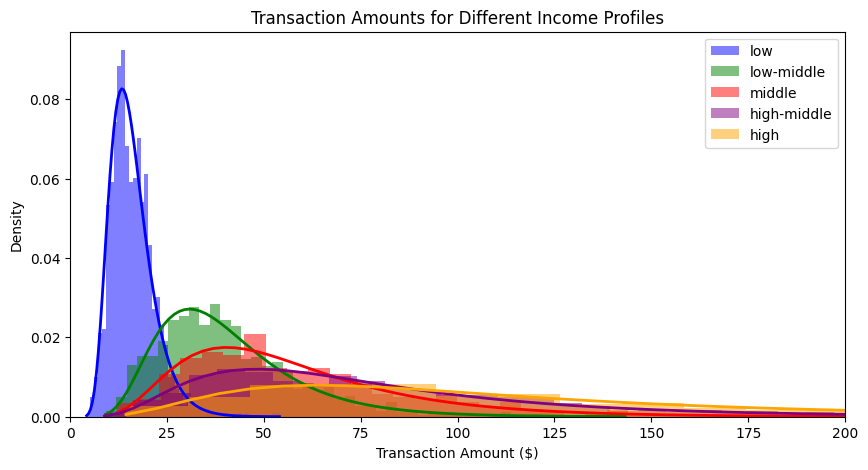

In [8]:
# Illustrating the spending habit of the groups above by generate 1000 transactions for a customer of each profile

# Set seed for reproducibility
random.seed(99)
np.random.seed(99)

colors = ['blue', 'green', 'red', 'purple', 'orange']
plt.figure(figsize=(10, 5))
for i, profile in enumerate(df["name"]):
    row = df[df["name"] == profile].iloc[0]
    profile_dict = row.to_dict()

    mean_amount = np.random.uniform(profile_dict["txn_mean_low"], profile_dict["txn_mean_high"])
    cv = np.random.uniform(profile_dict["txn_cv_low"], profile_dict["txn_cv_high"])
    sigma = compute_sigma(mean_amount, cv)
    txn_value = np.random.lognormal(mean=np.log(mean_amount), sigma=sigma, size=1000)
    
    # Plot histogram
    plt.hist(txn_value, bins=50, density=True, alpha=0.5, label=profile, color=colors[i])
    
    # Calculate and plot PDF
    x = np.linspace(txn_value.min(), txn_value.max(), 100)
    pdf = stats.lognorm.pdf(x, s=sigma, scale=np.exp(np.log(mean_amount)))
    plt.plot(x, pdf, color=colors[i], lw=2)

plt.xlim(0, 200)
plt.title('Transaction Amounts for Different Income Profiles')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Density')
plt.legend()
plt.show()

## 4. Generator and Customer Classes

In [9]:
# find current time
from datetime import datetime
datetime.now()

# convert to string
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2025-02-21 00:44:51'

In [67]:
from datetime import datetime, timedelta
from pydantic import BaseModel
from typing import List
from datetime import datetime


class GroupProfiles(BaseModel):
    name: List[str]
    txn_mean_low: List[float]
    txn_mean_high: List[float]
    txn_cv_low: List[float]
    txn_cv_high: List[float]
    txn_lambda: List[float]


class Customer:
    def __init__(self, profile: dict):
        self.profile = profile
        # self.customer_txns = []
        self._date_format = "%Y-%m-%d"
        self._timestamp_format = "%Y-%m-%d %H:%M:%S"
        self._big_ticket_proba = 0.005
        self._big_ticket_multiplier = 10 # Adjust the multiplier as needed

    def generate_txn_value(self):
        """
        Generate a single transaction value for a customer based on their profile
        In addition, there is a fixed probability (0.5%) of a big-ticket item
        """

        if np.random.rand() < self._big_ticket_proba: # rand() generates from uniform [0,1), thus there is 0.5% chance that the value is less than 0.005
            
            # Generate a big-ticket item
            big_ticket_mean = (
                self.profile["txn_mean"] * self._big_ticket_multiplier
            )  
            big_ticket_sigma = self.profile["txn_sigma"]
            txn_value = round(
                np.random.lognormal(
                    mean=np.log(big_ticket_mean),
                    sigma=big_ticket_sigma,
                ),
                2,
            )
        else:
            # Generate a regular transaction
            txn_value = round(
                np.random.lognormal(
                    mean=np.log(self.profile["txn_mean"]),
                    sigma=self.profile["txn_sigma"],
                ),
                2,
            )
        return txn_value
    
    def generate_current_txn(self):
        """ 
        Generate a single transaction for a customer based on their profile with the current timestamp
        """
        txn_value = self.generate_txn_value()
        txn_timestamp = datetime.now().strftime(self._timestamp_format)
        return {"txn_timestamp": txn_timestamp, "txn_value": txn_value}

    def generate_batch_txns(self, start_date: str = "2024-01-01", num_days: int = 30) -> List[dict]:
        """
        Gererate a list of customer transactions for a given number of days

        Parameters:
        -----------
        start_date: str
            The starting date of the transactions in the format 'YYYY-MM-DD'
        num_days: int
            The number of days for which to generate transactions

        Returns:
        --------
        None
            adds the generated transactions to the customer_txns attribute
        """
        batch_txns = []
        for day in range(num_days):
            num_txn = np.random.poisson(self.profile["txn_lambda"])
            if num_txn > 0:
                for _ in range(num_txn):
                    # Time of transaction: revolves around noontime, with std 20000 seconds. This is meant to simulate the fact that most transactions should occur during the day (e.g., grocery, gas, other shopping...)
                    time_txn = int(np.random.normal(86400 / 2, 20000))

                    if (time_txn > 0) and (time_txn < 86400):
                        txn_value = self.generate_txn_value()

                        txn_timestamp = datetime.fromtimestamp(
                            time_txn, tz=None
                        ) + timedelta(days=day)

                        txn_timestamp = datetime.strptime(
                            start_date, self._date_format
                        ) + timedelta(seconds=time_txn, days=day)

                        batch_txns.append(
                            {
                                # "day": day,
                                # "time_seconds": time_txn + day * 86400,
                                "txn_timestamp": txn_timestamp.strftime(
                                    self._timestamp_format
                                ),
                                "txn_value": txn_value,
                            }
                        )
        return batch_txns


class CustomerGenerator:
    def __init__(self, group_profiles: dict):
        """
        Initialize the CustomerGenerator with a dictionary of group profiles.
        
        Parameters:
        -----------
        group_profiles: dict
            A dictionary containing the group profiles for generating customer transactions.
            The dictionary must have the following structure where the key names and their value types are compulsory:
            {
                'name': ['low', 'low-middle', 'middle', 'high-middle', 'high'],
                'txn_mean_low': [5, 20, 40, 60, 80],
                'txn_mean_high': [20, 40, 60, 80, 100],
                'txn_cv_low': [0.3, 0.4, 0.5, 0.6, 0.7],
                'txn_cv_high': [0.4, 0.5, 0.6, 0.7, 0.8],
                'txn_lambda': [0.25, 0.5, 1, 1.5, 2]
            }

        """
        # validate the group_profiles
        try:
            GroupProfiles(**group_profiles)
        except ValidationError as e:
            raise ValueError(f"Invalid group_profiles data: {e}")
        
        self.group_profiles = self._convert_col_to_row_oriented_profile(
            group_profiles, "name"
        )

    def generate_customer_from_profile(self, profile_name: str):
        """ 
        Generate a customer object with a specific profile, modelled from the chosen profile name
        """
        assert profile_name in self.group_profiles.keys(), "Profile name not found"
        profile = self.group_profiles[profile_name]
        txn_mean = round(np.random.uniform(profile["txn_mean_low"], profile["txn_mean_high"]), 2)
        cv = round(np.random.uniform(profile["txn_cv_low"], profile["txn_cv_high"]),2)
        txn_sigma = round(self._compute_sigma(txn_mean, cv), 2)
        txn_lambda = profile["txn_lambda"]
        customer_profile = {
            "txn_mean": txn_mean,
            "txn_sigma": txn_sigma,
            "txn_lambda": txn_lambda,
        }
        return Customer(customer_profile)

    def _convert_col_to_row_oriented_profile(
        self, input_dict: dict, key_field: str
    ) -> dict:
        """
        Convert a column-oriented dictionary, which is more concise, to a row-oriented dictionary, which is easier to extract field-specific data from.

        Example:
        --------
        input_dict = {
            'key_field': ['A', 'B', 'C'],
            'field1': [1, 2, 3],
            'field2': [4, 5, 6]
        }
        output_dict = {
            'A': {'field1': 1, 'field2': 4},
            'B': {'field1': 2, 'field2': 5},
            'C': {'field1': 3, 'field2': 6}
        }
        """
        assert (
            key_field in input_dict
        ), f"Key field '{key_field}' not found in input dictionary"
        output_dict = {}
        key_values = input_dict[key_field]
        other_fields = {k: v for k, v in input_dict.items() if k != key_field}

        for i, key in enumerate(key_values):
            output_dict[key] = {
                field: values[i] for field, values in other_fields.items()
            }

        return output_dict
    
    def _compute_sigma(self, mean:float, cv:float) -> float:
        """ 
        Calculate sigma from mean and the coefficient of variation (CV)
        """
        variance = (mean * cv)**2
        sigma_sq = np.log(1 + variance/(mean**2))
        sigma = np.sqrt(sigma_sq)
        # get the value from numpy array
        return sigma.item()

{'txn_mean': 52.13155282239804, 'txn_sigma': 0.5491218980521271, 'txn_lambda': 1}
Average total transaction value: $1934.2


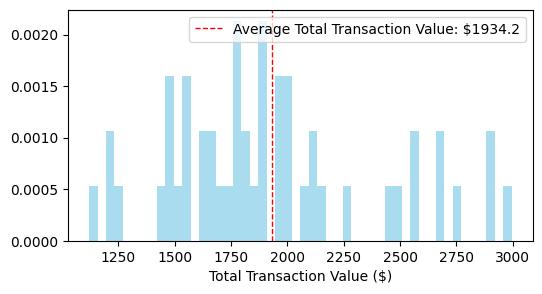

In [11]:
# Trials to finetune the profiles

customer_generator = CustomerGenerator(group_profiles)
customer = customer_generator.generate_customer_from_profile("middle")
print(customer.profile)

num_days = 30
num_trials = 50
total_txn_values = []
for trial in range(num_trials):
    
    customer_txns = customer.generate_batch_txns(num_days=num_days)
    total_txn_values.append(round(sum([txn["txn_value"] for txn in customer_txns]), 2))
# average total transaction value over all trials
avg_total_txn_value = round(np.mean(total_txn_values), 2)
print(f"Average total transaction value: ${avg_total_txn_value}")
# Plot histogram
plt.figure(figsize=(6, 3))
plt.hist(total_txn_values, bins=50, density=True, alpha=0.7, color="skyblue")
plt.xlabel("Total Transaction Value ($)")
# add average total transaction value to the plot
plt.axvline(
    avg_total_txn_value,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label=f"Average Total Transaction Value: ${avg_total_txn_value}",
)
plt.legend()

In [12]:
customer_generator = CustomerGenerator(group_profiles)
customer = customer_generator.generate_customer_from_profile("middle")
print(customer.profile)

sample_txn = customer.generate_txn_value()
print(f"Sample transaction value: ${sample_txn}")

num_days=30

customer_txns = customer.generate_batch_txns(num_days=num_days, start_date="2024-01-01")
# customer_txns = customer.customer_txns

total_txn_value = round(sum([txn["txn_value"] for txn in customer_txns]), 2)
print(f"Total transaction value in {num_days} days: ${total_txn_value}")

customer_txns[:5]

{'txn_mean': 50.8966788689801, 'txn_sigma': 0.5499947582008062, 'txn_lambda': 1}
Sample transaction value: $18.88
Total transaction value in 30 days: $1731.9


[{'txn_timestamp': '2024-01-02 08:53:16', 'txn_value': 66.16},
 {'txn_timestamp': '2024-01-04 11:46:07', 'txn_value': 37.92},
 {'txn_timestamp': '2024-01-06 11:14:01', 'txn_value': 50.61},
 {'txn_timestamp': '2024-01-06 11:45:21', 'txn_value': 57.08},
 {'txn_timestamp': '2024-01-07 07:44:56', 'txn_value': 21.85}]

## 5. Generate a sample dataset without fraud

1. Generate 100 customers with random profile
2. For each customer, generate 1 year of transactions


In [129]:
group_profiles

{'name': ['low', 'low-middle', 'middle', 'high-middle', 'high'],
 'txn_mean_low': [5, 20, 40, 60, 80],
 'txn_mean_high': [20, 40, 60, 80, 100],
 'txn_cv_low': [0.3, 0.4, 0.5, 0.6, 0.7],
 'txn_cv_high': [0.4, 0.5, 0.6, 0.7, 0.8],
 'txn_lambda': [0.25, 0.5, 1, 1.5, 2]}

In [130]:
start_date="2024-01-01"
num_days=365
txn_data = []
customer_data = []
num_customers = 1000

for i in range(1,num_customers+1):
    customer_id_num = 1000000 + i
    customer_id = f"c_{str(1000000 + i)[1:]}"
    customer_generator = CustomerGenerator(group_profiles)
    profile_name = random.choice(group_profiles["name"])
    customer = customer_generator.generate_customer_from_profile(profile_name)
    customer_txns = customer.generate_batch_txns(num_days=num_days, start_date=start_date)
    txn_data.append({"customer_id":customer_id, "customer_txns":customer_txns})
    customer_dict = customer.profile
    customer_dict["customer_id"] = customer_id
    customer_dict["profile_name"] = profile_name
    customer_data.append(customer_dict)

In [131]:
# convert the dataset to a dataframe, with each row representing a transaction, and customer_id as a column
df_txns = pd.DataFrame(
    [
        {"customer_id": row["customer_id"], **txn}
        for row in txn_data
        for txn in row["customer_txns"]
    ]
)
# add a unique transaction ID
df_txns["txn_id"] = df_txns.index.map(lambda x: f"t_{uuid.uuid4().hex[:10]}")
# rearrange by timestamp to simulate the real-world scenario
df_txns.sort_values(by="txn_timestamp", inplace=True)
df_txns.reset_index(drop=True, inplace=True)

df_customers = pd.DataFrame(customer_data)

In [132]:
df_txns

,customer_id,txn_timestamp,txn_value,txn_id
0,c_000758,2024-01-01 00:03:54,107.57,t_cd236c6d02
1,c_000554,2024-01-01 00:04:58,22.98,t_4dc9d90b3b
2,c_000327,2024-01-01 00:07:16,70.97,t_d9dedc5462
3,c_000409,2024-01-01 00:12:58,154.64,t_bb4bcb929e
4,c_000567,2024-01-01 00:17:14,63.31,t_a31b1347da
...,...,...,...,...
379625,c_000717,2024-12-30 23:47:15,29.31,t_dfd5977170
379626,c_000543,2024-12-30 23:49:58,82.26,t_76bda3b7c5
379627,c_000503,2024-12-30 23:52:38,55.75,t_4f4a870ee6
379628,c_000283,2024-12-30 23:56:22,279.47,t_6157542161


In [133]:
df_customers

,txn_mean,txn_sigma,txn_lambda,customer_id,profile_name
0,8.97,0.32,0.25,c_000001,low
1,94.13,0.70,2.00,c_000002,high
2,51.74,0.51,1.00,c_000003,middle
3,97.05,0.66,2.00,c_000004,high
4,40.29,0.50,1.00,c_000005,middle
...,...,...,...,...,...
995,13.74,0.30,0.25,c_000996,low
996,5.11,0.34,0.25,c_000997,low
997,51.69,0.54,1.00,c_000998,middle
998,61.89,0.57,1.50,c_000999,high-middle


## 6. Fraud Scenarios

Recency, Frequency, Monetary:
1. Rule-based: Anything >5000 is marked as fraud.
2. Small transactions in very quick successions. E.g., 5-10 transactions in 5 minutes.
3. Large transactions in quick successions. E.g., 2-3 transactions of uniform(1000, 10000) in 5 minutes.
4. A large transaction followed by a small transaction. E.g., uniform(1000, 10000) followed by uniform(100, 1000) in 5 minutes.


In [142]:
scenario_1_customers = df_txns[df_txns['txn_value'] > 5000]['customer_id'].to_list()
scenario_1_customers 

['c_000923',
 'c_000623',
 'c_000373',
 'c_000343',
 'c_000634',
 'c_000885',
 'c_000530']

In [143]:
# get rows in df_customers from scenario_1_customers 
df_customers[df_customers['customer_id'].isin(scenario_1_customers)]

,txn_mean,txn_sigma,txn_lambda,customer_id,profile_name
342,98.82,0.64,2.0,c_000343,high
372,99.97,0.66,2.0,c_000373,high
529,99.28,0.65,2.0,c_000530,high
622,85.14,0.70,2.0,c_000623,high
633,81.35,0.65,2.0,c_000634,high
884,90.95,0.64,2.0,c_000885,high
922,92.64,0.70,2.0,c_000923,high
